<a href="https://colab.research.google.com/github/AdrienVansuyt/Python-Quant-Exercices/blob/main/BTC_BOT_%24%24%24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BOT Single print BTC SELL ONLY**

## **2 years period**

[*********************100%%**********************]  1 of 1 completed
<ipython-input-6-5d772ddf696e>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
<ipython-input-6-5d772ddf696e>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_prints['sell'].append((data.index[i], data['High'][i]))
<ipython-input-6-5d772ddf696e>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24057.580078125 (TP), PnL: 41200.00, Capital Before: 10000.00, Position Size: 80.00, Capital After: 51200.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23063.650390625 (TP), PnL: 41200.00, Capital Before: 51200.00, Position Size: 80.00, Capital After: 92400.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22907.828125 (TP), PnL: 41200.00, Capital Before: 92400.00, Position Size: 80.00, Capital After: 133600.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23688.689453125 (TP), PnL: 41200.00, Capital Before: 133600.00, Position Size: 80.00, Capital After: 174800.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24307.62890625 (TP), PnL: 41200.00, Capital Before: 174800.00, Position Size: 80.00, Capital After: 216000.0

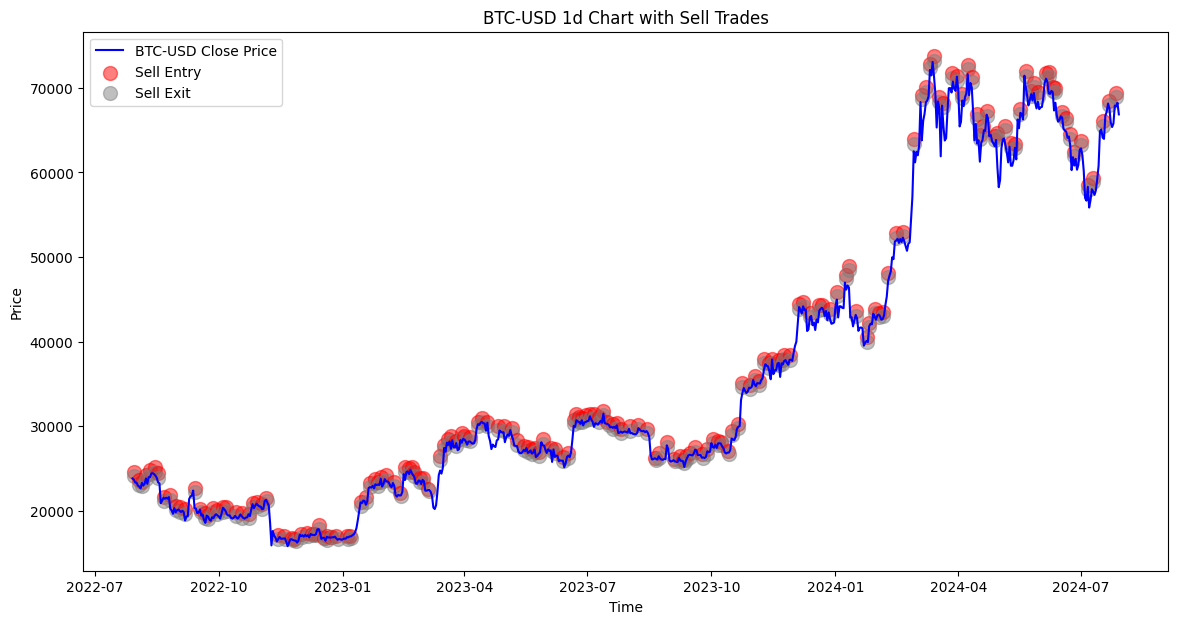


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24057.58     TP  41200.0   
1   2022-08-03     23578.65 2022-08-03    23063.65     TP  41200.0   
2   2022-08-05     23422.83 2022-08-05    22907.83     TP  41200.0   
3   2022-08-08     24203.69 2022-08-08    23688.69     TP  41200.0   
4   2022-08-11     24822.63 2022-08-11    24307.63     TP  41200.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57957.55     TP  41200.0   
181 2024-07-10     59359.43 2024-07-10    58844.43     TP  41200.0   
182 2024-07-17     66066.73 2024-07-17    65551.73     TP  41200.0   
183 2024-07-22     68480.06 2024-07-22    67965.06     TP  41200.0   
184 2024-07-27     69398.51 2024-07-27    68883.51     TP  41200.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0           80.0              51200.0  
1        

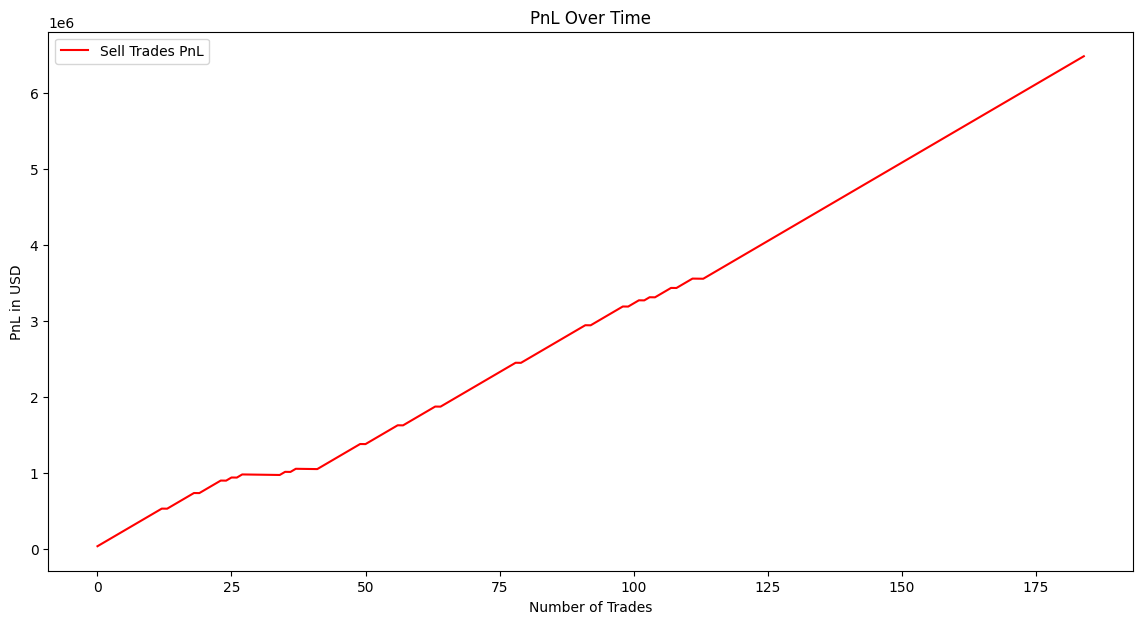

In [6]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 25
tp_pips = 515
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()

40 de taille de position fixe

[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-dc1bd9d913fd>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
<ipython-input-8-dc1bd9d913fd>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_prints['sell'].append((data.index[i], data['High'][i]))
<ipython-input-8-dc1bd9d913fd>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24057.580078125 (TP), PnL: 20600.00, Capital Before: 10000.00, Position Size: 40.00, Capital After: 30600.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23063.650390625 (TP), PnL: 20600.00, Capital Before: 30600.00, Position Size: 40.00, Capital After: 51200.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22907.828125 (TP), PnL: 20600.00, Capital Before: 51200.00, Position Size: 40.00, Capital After: 71800.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23688.689453125 (TP), PnL: 20600.00, Capital Before: 71800.00, Position Size: 40.00, Capital After: 92400.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24307.62890625 (TP), PnL: 20600.00, Capital Before: 92400.00, Position Size: 40.00, Capital After: 113000.00
Se

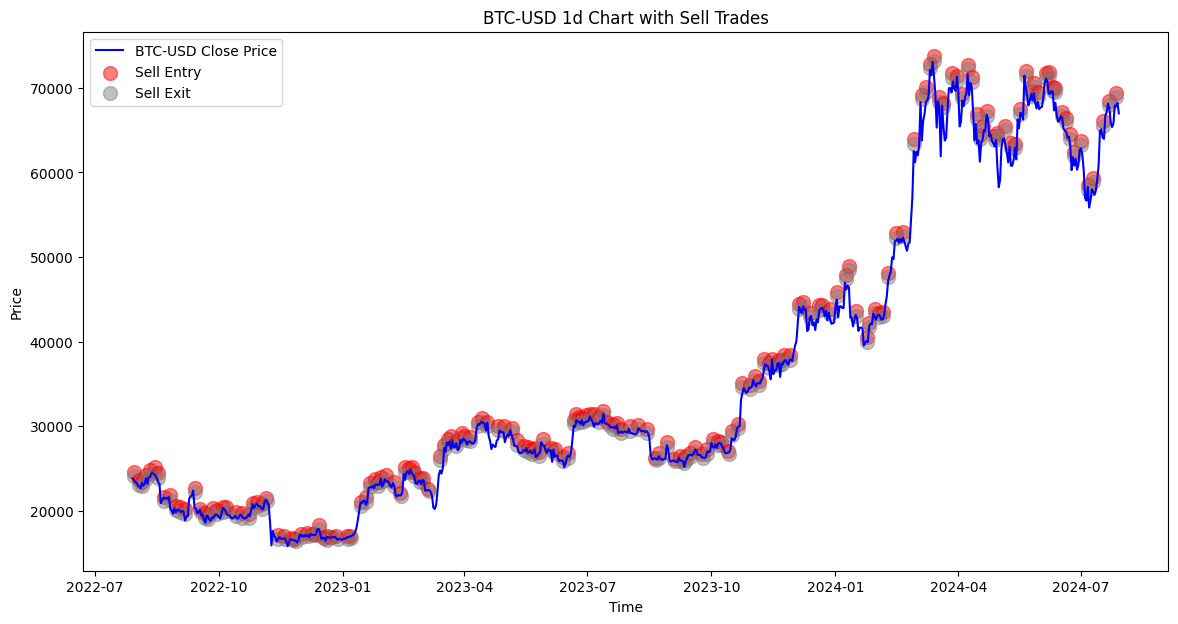


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24057.58     TP  20600.0   
1   2022-08-03     23578.65 2022-08-03    23063.65     TP  20600.0   
2   2022-08-05     23422.83 2022-08-05    22907.83     TP  20600.0   
3   2022-08-08     24203.69 2022-08-08    23688.69     TP  20600.0   
4   2022-08-11     24822.63 2022-08-11    24307.63     TP  20600.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57957.55     TP  20600.0   
181 2024-07-10     59359.43 2024-07-10    58844.43     TP  20600.0   
182 2024-07-17     66066.73 2024-07-17    65551.73     TP  20600.0   
183 2024-07-22     68480.06 2024-07-22    67965.06     TP  20600.0   
184 2024-07-27     69398.51 2024-07-27    68883.51     TP  20600.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0             40              30600.0  
1        

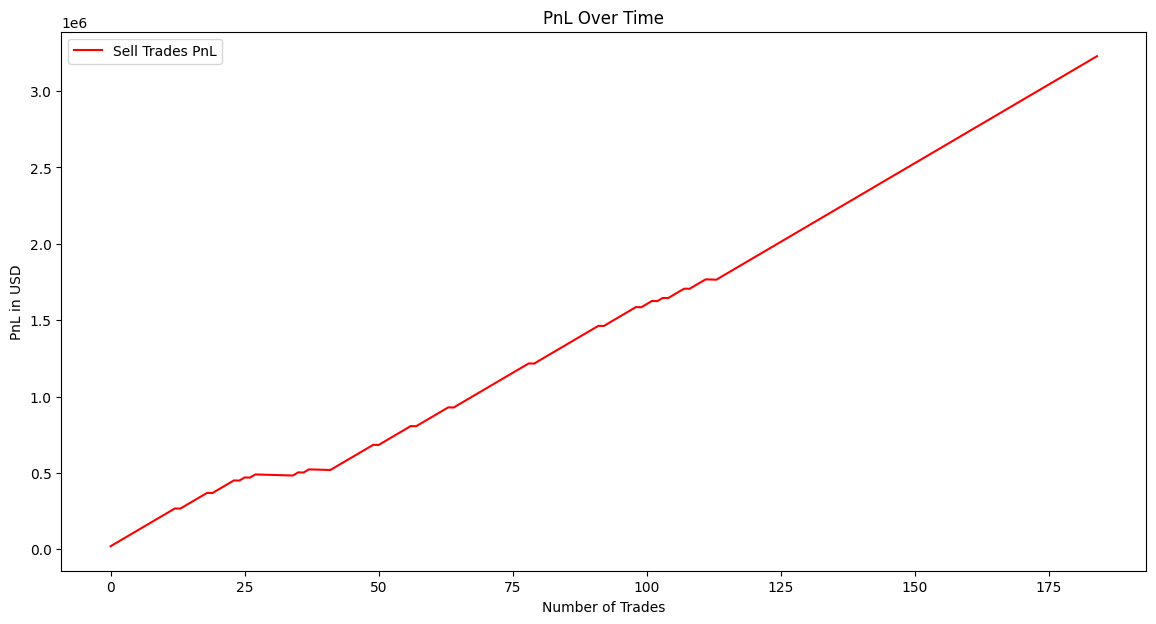

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
position_size = 40  # Taille de position fixe
sl_pips = 25
tp_pips = 515
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, position_size):
    trades = {'sell': []}
    capital = initial_capital
    max_risk_per_trade = capital * 0.10  # 10% du capital initial par trade

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, position_size)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


6 mois d'historique / 40 contrats

[*********************100%%**********************]  1 of 1 completed
<ipython-input-9-1e3cf786838c>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
<ipython-input-9-1e3cf786838c>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_prints['sell'].append((data.index[i], data['High'][i]))
<ipython-input-9-1e3cf786838c>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

Sell trade: Entry on 2024-01-30 00:00:00 at 43838.9453125, Exit on 2024-01-30 00:00:00 at 43323.9453125 (TP), PnL: 20600.00, Capital Before: 10000.00, Position Size: 40.00, Capital After: 30600.00
Sell trade: Entry on 2024-02-02 00:00:00 at 43422.48828125, Exit on 2024-02-02 00:00:00 at 42907.48828125 (TP), PnL: 20600.00, Capital Before: 30600.00, Position Size: 40.00, Capital After: 51200.00
Sell trade: Entry on 2024-02-05 00:00:00 at 43494.25, Exit on 2024-02-05 00:00:00 at 42979.25 (TP), PnL: 20600.00, Capital Before: 51200.00, Position Size: 40.00, Capital After: 71800.00
Sell trade: Entry on 2024-02-09 00:00:00 at 48152.49609375, Exit on 2024-02-09 00:00:00 at 47637.49609375 (TP), PnL: 20600.00, Capital Before: 71800.00, Position Size: 40.00, Capital After: 92400.00
Sell trade: Entry on 2024-02-15 00:00:00 at 52820.06640625, Exit on 2024-02-15 00:00:00 at 52305.06640625 (TP), PnL: 20600.00, Capital Before: 92400.00, Position Size: 40.00, Capital After: 113000.00
Sell trade: Entry 

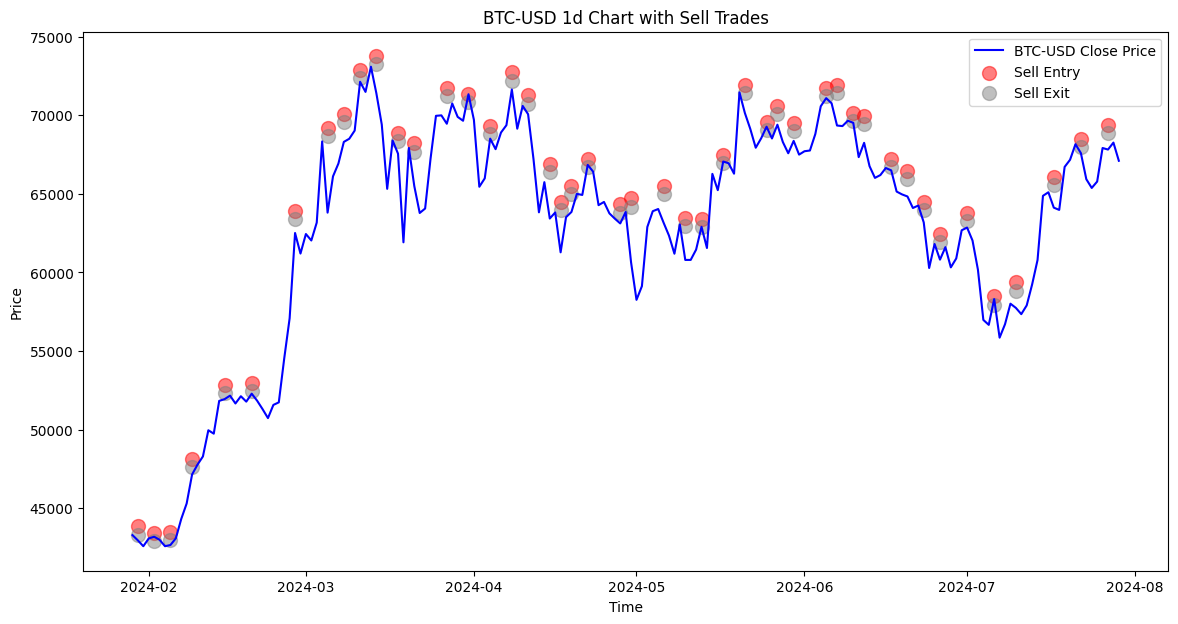


PnL for Sell Trades:
   Entry Date  Entry Price  Exit Date  Exit Price Result    PnL  \
0  2024-01-30     43838.95 2024-01-30    43323.95     TP  20600   
1  2024-02-02     43422.49 2024-02-02    42907.49     TP  20600   
2  2024-02-05     43494.25 2024-02-05    42979.25     TP  20600   
3  2024-02-09     48152.50 2024-02-09    47637.50     TP  20600   
4  2024-02-15     52820.07 2024-02-15    52305.07     TP  20600   
5  2024-02-20     52945.05 2024-02-20    52430.05     TP  20600   
6  2024-02-28     63913.13 2024-02-28    63398.13     TP  20600   
7  2024-03-05     69170.62 2024-03-05    68655.62     TP  20600   
8  2024-03-08     70083.05 2024-03-08    69568.05     TP  20600   
9  2024-03-11     72850.71 2024-03-11    72335.71     TP  20600   
10 2024-03-14     73750.07 2024-03-14    73235.07     TP  20600   
11 2024-03-18     68897.13 2024-03-18    68382.13     TP  20600   
12 2024-03-21     68199.99 2024-03-21    67684.99     TP  20600   
13 2024-03-27     71727.69 2024-03-27   

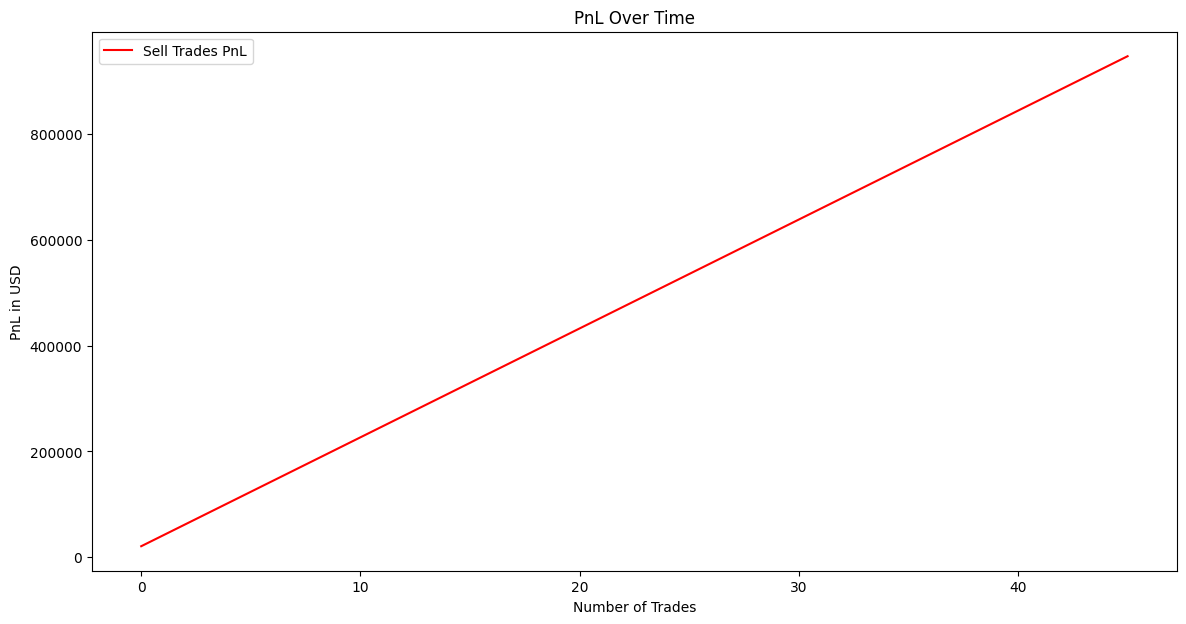

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '6mo'
initial_capital = 10000
position_size = 40  # Taille de position fixe
sl_pips = 25
tp_pips = 515
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, position_size):
    trades = {'sell': []}
    capital = initial_capital
    max_risk_per_trade = capital * 0.10  # 10% du capital initial par trade

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, position_size)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed
<ipython-input-10-ddc5d61a313d>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
<ipython-input-10-ddc5d61a313d>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_prints['sell'].append((data.index[i], data['High'][i]))
<ipython-input-10-ddc5d61a313d>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24057.580078125 (TP), PnL: 20600.00, Capital Before: 10000.00, Position Size: 40.00, Capital After: 30600.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23063.650390625 (TP), PnL: 20600.00, Capital Before: 30600.00, Position Size: 40.00, Capital After: 51200.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22907.828125 (TP), PnL: 20600.00, Capital Before: 51200.00, Position Size: 40.00, Capital After: 71800.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23688.689453125 (TP), PnL: 20600.00, Capital Before: 71800.00, Position Size: 40.00, Capital After: 92400.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24307.62890625 (TP), PnL: 20600.00, Capital Before: 92400.00, Position Size: 40.00, Capital After: 113000.00
Se

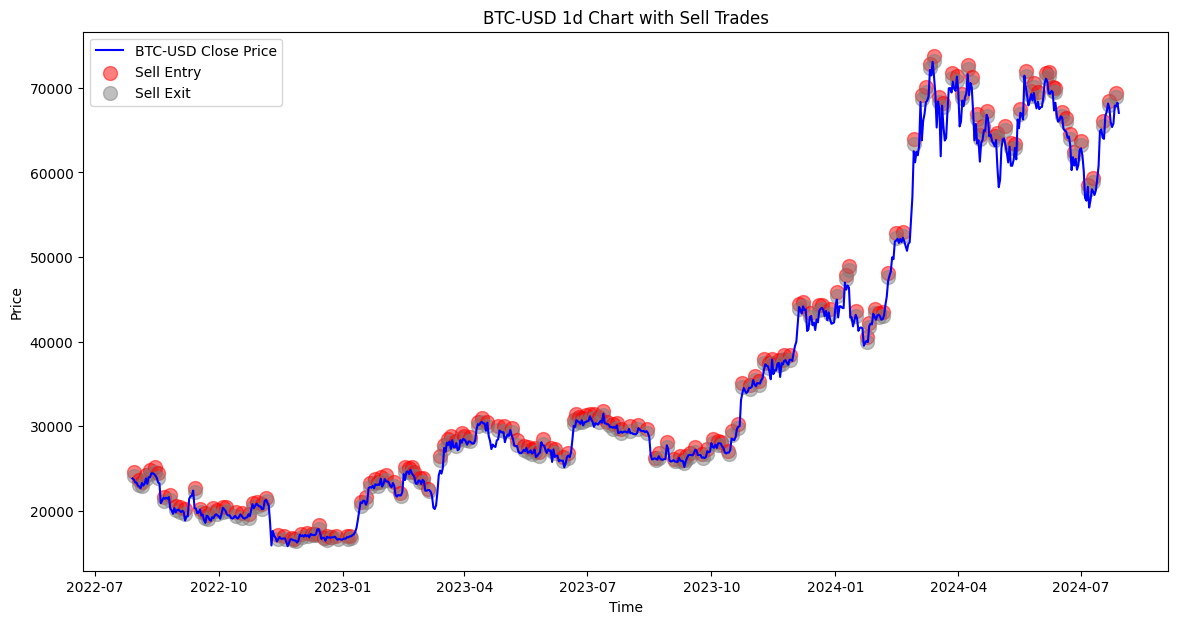


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24057.58     TP  20600.0   
1   2022-08-03     23578.65 2022-08-03    23063.65     TP  20600.0   
2   2022-08-05     23422.83 2022-08-05    22907.83     TP  20600.0   
3   2022-08-08     24203.69 2022-08-08    23688.69     TP  20600.0   
4   2022-08-11     24822.63 2022-08-11    24307.63     TP  20600.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57957.55     TP  20600.0   
181 2024-07-10     59359.43 2024-07-10    58844.43     TP  20600.0   
182 2024-07-17     66066.73 2024-07-17    65551.73     TP  20600.0   
183 2024-07-22     68480.06 2024-07-22    67965.06     TP  20600.0   
184 2024-07-27     69398.51 2024-07-27    68883.51     TP  20600.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0             40              30600.0  
1        

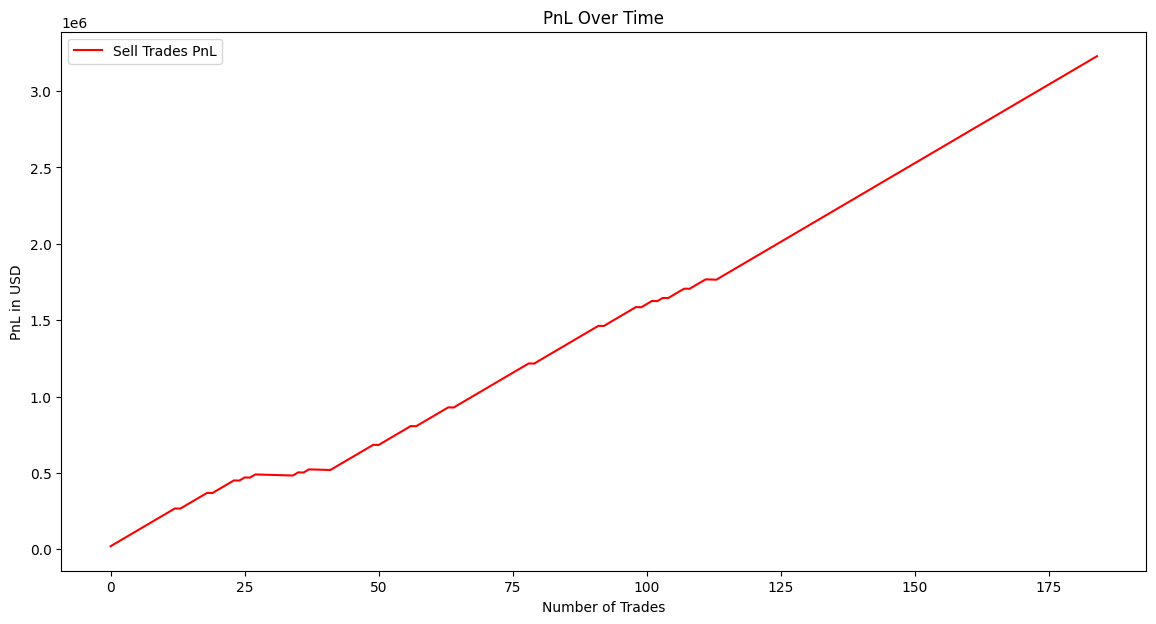

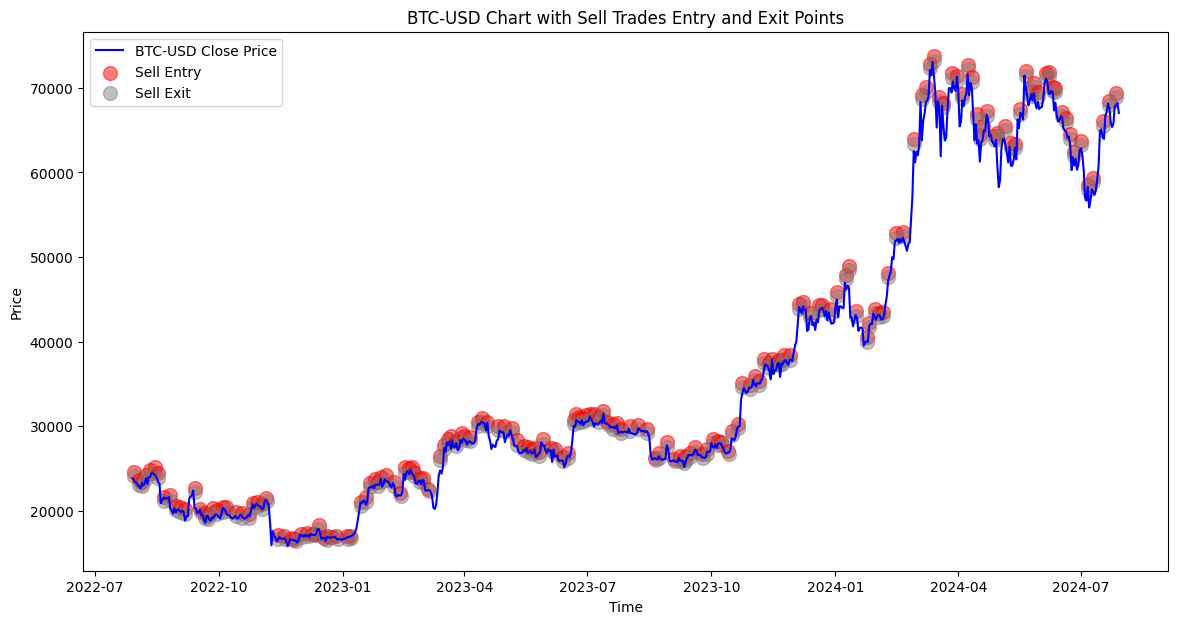

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
position_size = 40  # Taille de position fixe
sl_pips = 25
tp_pips = 515
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, position_size):
    trades = {'sell': []}
    capital = initial_capital
    max_risk_per_trade = capital * 0.10  # 10% du capital initial par trade

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, position_size)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()

# Tracer les graphiques des points d'entrée et de sortie des trades
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

for trade in trades['sell']:
    entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
    plt.scatter(entry_date, entry_price, color='red', s=100, alpha=0.5, label='Sell Entry' if trade == trades['sell'][0] else "")
    plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label='Sell Exit' if trade == trades['sell'][0] else "")

plt.title('BTC-USD Chart with Sell Trades Entry and Exit Points')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
